In [1]:
from neuron import h
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
h.load_file('stdrun.hoc')
T=3055
simdur =400*T

In [2]:

def performance(gsyn12, gsyn21, gfb12, gfb21, plot=False):
    # Setup the brain-body system
    sec = h.Section(name='mod')
    sec.insert('brainb')
    sec.insert('bodyb')
    seg = sec(0.5)

    # Set parameters
    seg.brainb.gsyn12 = gsyn12
    seg.brainb.gsyn21 = gsyn21
    seg.brainb.gfb12 = gfb12
    seg.brainb.gfb21 = gfb21

    # Wire pointers
    seg.brainb._ref_L1Pointer = seg.bodyb._ref_L1
    seg.brainb._ref_L2Pointer = seg.bodyb._ref_L2
    seg.bodyb._ref_V1Pointer = seg.brainb._ref_V1
    seg.bodyb._ref_V2Pointer = seg.brainb._ref_V2

    # Record Q and V1 and time
    Qv = h.Vector().record(seg.bodyb._ref_Q)
    V1v = h.Vector().record(seg.brainb._ref_V1)
    tv = h.Vector().record(h._ref_t)

    # Run simulation
    h.finitialize()
    h.cvode.active(1)
    h.continuerun(simdur)

    # Convert to NumPy
    Q = np.array(Qv)
    V1 = np.array(V1v)
    t = np.array(tv)

    try:
        # Detect peaks in V1
        peaks, _ = find_peaks(V1, height=np.max(V1)*0.5, distance=0.5*T)

        if len(peaks) >= 2:
            start_idx, end_idx = peaks[-2], peaks[-1]
            t_start, t_end = t[start_idx], t[end_idx]
            Q_start, Q_end = Q[start_idx], Q[end_idx]
            perf = (Q_end - Q_start) / (t_end - t_start)

            if plot:
                plt.figure(figsize=(10, 4))
                plt.plot(t, V1, label='V1')
                plt.axvline(t_start, color='green', linestyle='--', label='Cycle Start')
                plt.axvline(t_end, color='red', linestyle='--', label='Cycle End')
                plt.title(f'Limit Cycle Detection (gsyn12={gsyn12}, gsyn21={gsyn21})')
                plt.xlabel('Time (ms)')
                plt.ylabel('V1')
                plt.legend()
                plt.grid(True)
                plt.show()
                

            return perf

        else:
            # Not enough peaks -> fallback
            t_start, t_end = t[0], t[-1]
            Q_start, Q_end = Q[0], Q[-1]
            avg_perf = (Q_end - Q_start) / (t_end - t_start)
            if plot:
                print(" Not enough peaks. Fallback to ΔQ/Δt over full sim.")
            return avg_perf

    except Exception as e:
        # Peak detection failed
        t_start, t_end = t[0], t[-1]
        Q_start, Q_end = Q[0], Q[-1]
        avg_perf = (Q_end - Q_start) / (t_end - t_start)
        if plot:
            print(f" Peak detection failed: {e}")
         
        return avg_perf


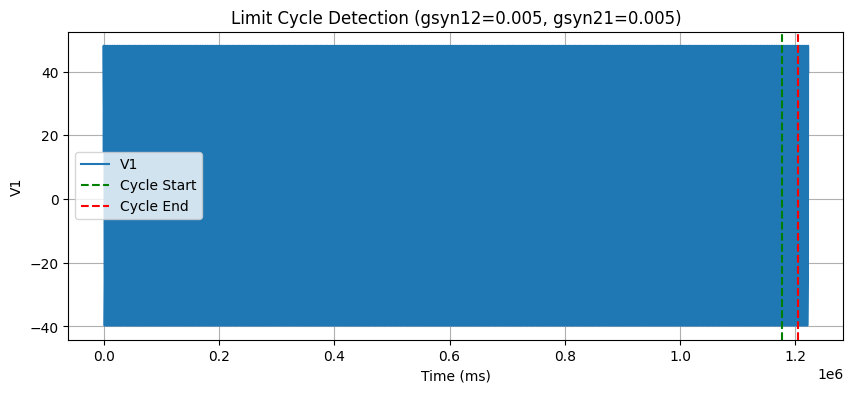

Baseline performance (symmetric): 1.23e-03


In [3]:
original_gsyn12 = 0.005
original_gsyn21 = 0.005
original_gfb12  = 0.001
original_gfb21  = 0.001

original_perf = performance(original_gsyn12, original_gsyn21, original_gfb12, original_gfb21, plot=True)
print(f"Baseline performance (symmetric): {original_perf:.2e}")


In [4]:
gsyn12_vals = np.linspace(0.0005, 0.03, 20)
perf_gsyn12 = [performance(g, original_gsyn21, original_gfb12, original_gfb21) for g in gsyn12_vals]
opt_gsyn12 = gsyn12_vals[np.argmax(perf_gsyn12)]
print(f"Optimal gsyn12 = {opt_gsyn12:.6f}, Perf = {max(perf_gsyn12):.2e}")
gsyn21_vals = np.linspace(0.0006, 0.03, 20)
perf_gsyn21 = [performance(original_gsyn21,g, original_gfb12, original_gfb21) for g in gsyn21_vals]
opt_gsyn21 = gsyn21_vals[np.argmax(perf_gsyn21)]
print(f" Optimal gsyn21 = {opt_gsyn21:.6f}, Perf = {max(perf_gsyn21):.2e}")

Optimal gsyn12 = 0.003605, Perf = 1.26e-03
 Optimal gsyn21 = 0.003695, Perf = 1.23e-03


 grid optimum :gsyn12=0.003245, gsyn21=0.004064, Perf=1.27e-03


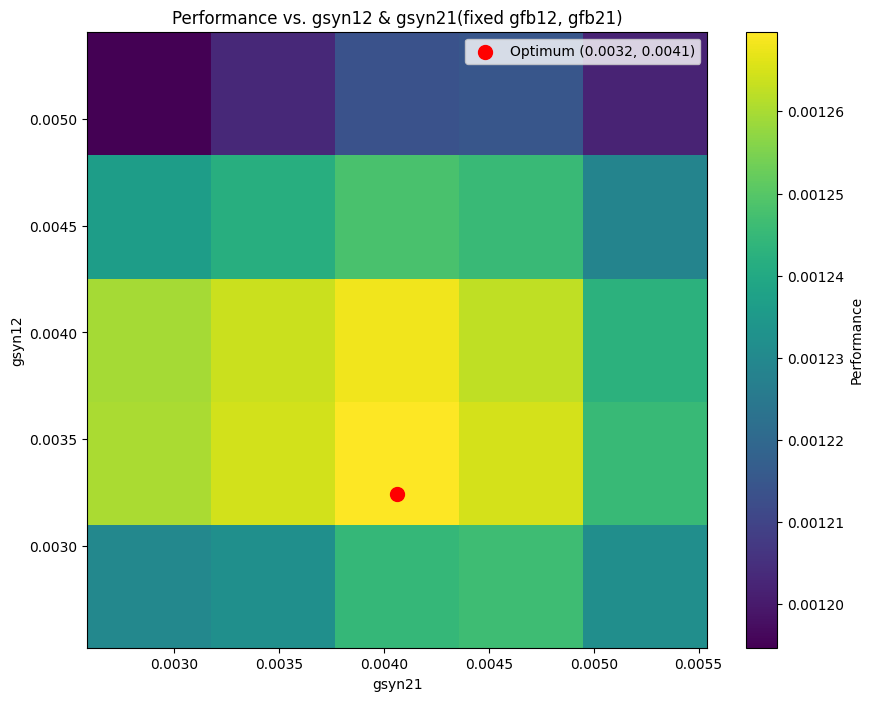

In [5]:

gsyn12_range = np.linspace(opt_gsyn12 * 0.7, opt_gsyn12 * 1.5, 5)
gsyn21_range = np.linspace(opt_gsyn21 * 0.7, opt_gsyn21 * 1.5, 5)

performance_grid = np.zeros((len(gsyn12_range), len(gsyn21_range)))
for i, gs12 in enumerate(gsyn12_range):
    for j, gs21 in enumerate(gsyn21_range):
        performance_grid[i, j] = performance(
            gs12, gs21, original_gfb12, original_gfb21
        )

i_opt, j_opt = np.unravel_index(np.argmax(performance_grid), performance_grid.shape)
opt12, opt21 = gsyn12_range[i_opt], gsyn21_range[j_opt]
opt_perf = performance_grid[i_opt, j_opt]
print(f" grid optimum :gsyn12={opt12:.6f}, gsyn21={opt21:.6f}, Perf={opt_perf:.2e}")

# plot
plt.figure(figsize=(10, 8))
im = plt.imshow(
    performance_grid,
    origin='lower',
    extent=(gsyn21_range[0], gsyn21_range[-1],
            gsyn12_range[0], gsyn12_range[-1]),
    aspect='auto',
    cmap='viridis'
)
plt.scatter(opt21, opt12, color='red', s=100,
            label=f'Optimum ({opt12:.4f}, {opt21:.4f})')
cbar = plt.colorbar(im, label='Performance')
plt.xlabel('gsyn21')
plt.ylabel('gsyn12')
plt.title('Performance vs. gsyn12 & gsyn21(fixed gfb12, gfb21)')
plt.legend()
plt.show()


In [7]:

gfb12_vals = np.linspace(0.0001, 0.005, 20)
perf_gfb12 = [performance(original_gsyn12, original_gsyn21, g, original_gfb21) for g in gfb12_vals]
opt_gfb12 = gfb12_vals[np.argmax(perf_gfb12)]
print(f"Best gfb12 = {opt_gfb12:.6f}, Perf = {max(perf_gfb12):.2e}")

gfb21_vals = np.linspace(0.0001, 0.005, 20)
perf_gfb21 = [performance(original_gsyn12, original_gsyn21, original_gfb12, g) for g in gfb21_vals]
opt_gfb21 = gfb21_vals[np.argmax(perf_gfb21)]
print(f"Best gfb21 = {opt_gfb21:.6f}, Perf = {max(perf_gfb21):.2e}")


Best gfb12 = 0.000100, Perf = 1.28e-03
Best gfb21 = 0.000358, Perf = 1.24e-03


Grid optimum: gfb12=0.000070, gfb21=0.000251, Perf=1.30e-03


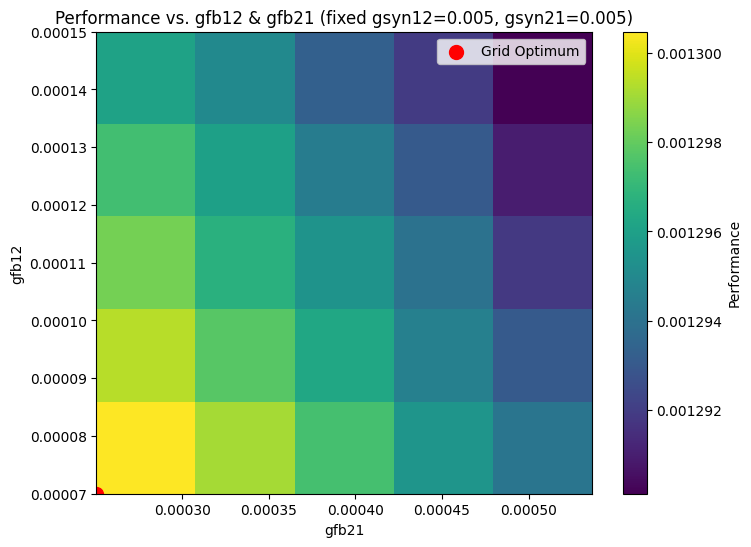

In [8]:
gfb12_range = np.linspace(opt_gfb12 * 0.7, opt_gfb12 * 1.5, 5)
gfb21_range = np.linspace(opt_gfb21 * 0.7, opt_gfb21 * 1.5, 5)

performance_grid = np.zeros((len(gfb12_range), len(gfb21_range)))
for i, gf12 in enumerate(gfb12_range):
    for j, gf21 in enumerate(gfb21_range):
        performance_grid[i, j] = performance(
            original_gsyn12, original_gsyn21, gf12, gf21
        )

# find the grid maximum
i_opt, j_opt = np.unravel_index(np.argmax(performance_grid), performance_grid.shape)
opt_g12 = gfb12_range[i_opt]
opt_g21 = gfb21_range[j_opt]
opt_perf = performance_grid[i_opt, j_opt]

print(f"Grid optimum: gfb12={opt_g12:.6f}, gfb21={opt_g21:.6f}, Perf={opt_perf:.2e}")

# plot it
plt.figure(figsize=(8, 6))
im = plt.imshow(
    performance_grid,
    origin='lower',
    extent=(gfb21_range[0], gfb21_range[-1], gfb12_range[0], gfb12_range[-1]),
    aspect='auto',
    cmap='viridis'
)
plt.scatter(opt_g21, opt_g12, color='red', s=100, label='Grid Optimum')
plt.colorbar(im, label='Performance')
plt.xlabel('gfb21')
plt.ylabel('gfb12')
plt.title('Performance vs. gfb12 & gfb21 (fixed gsyn12=0.005, gsyn21=0.005)')
plt.legend()
plt.show()


In [9]:

gsyn12_range = np.linspace(opt_gsyn12 * 0.7, opt_gsyn12 * 1.5, 5)
gsyn21_range = np.linspace(opt_gsyn21 * 0.8, opt_gsyn21 * 1.2, 5)
gfb12_range = np.linspace(opt_gfb12 * 0.6, opt_gfb12 * 1.4, 5)
gfb21_range = np.linspace(opt_gfb21 * 0.75, opt_gfb21 * 1.3, 5)

best_perf = -np.inf
best_params = (0, 0, 0, 0)

for gs12 in gsyn12_range:
    for gs21 in gsyn21_range:
        for gf12 in gfb12_range:
            for gf21 in gfb21_range:
                current_perf = performance(gs12, gs21, gf12, gf21)
                if current_perf > best_perf:
                    best_perf = current_perf
                    best_params = (gs12, gs21, gf12, gf21)
                print(f"gs12={gs12:.4f}, gs21={gs21:.4f}, gf12={gf12:.4f}, gf21={gf21:.4f}, Perf={current_perf:.4e}")

print(f"\n Optimal parameters: gsyn12={best_params[0]:.6f}, gsyn21={best_params[1]:.6f}, gfb12={best_params[2]:.6f}, gfb21={best_params[3]:.6f}")
print(f" Best performance: {best_perf:.2e}")

gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0003, Perf=1.2590e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0003, Perf=1.2605e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0004, Perf=1.2634e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0004, Perf=1.2656e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0005, Perf=1.2671e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0003, Perf=1.2569e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0003, Perf=1.2598e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0004, Perf=1.2622e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0004, Perf=1.2645e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0005, Perf=1.2664e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0003, Perf=1.2562e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0003, Perf=1.2583e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0004, Perf=1.2609e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.0004, Perf=1.2632e-03
gs12=0.0025, gs21=0.0030, gf12=0.0001, gf21=0.00

Changed dt
Changed dt


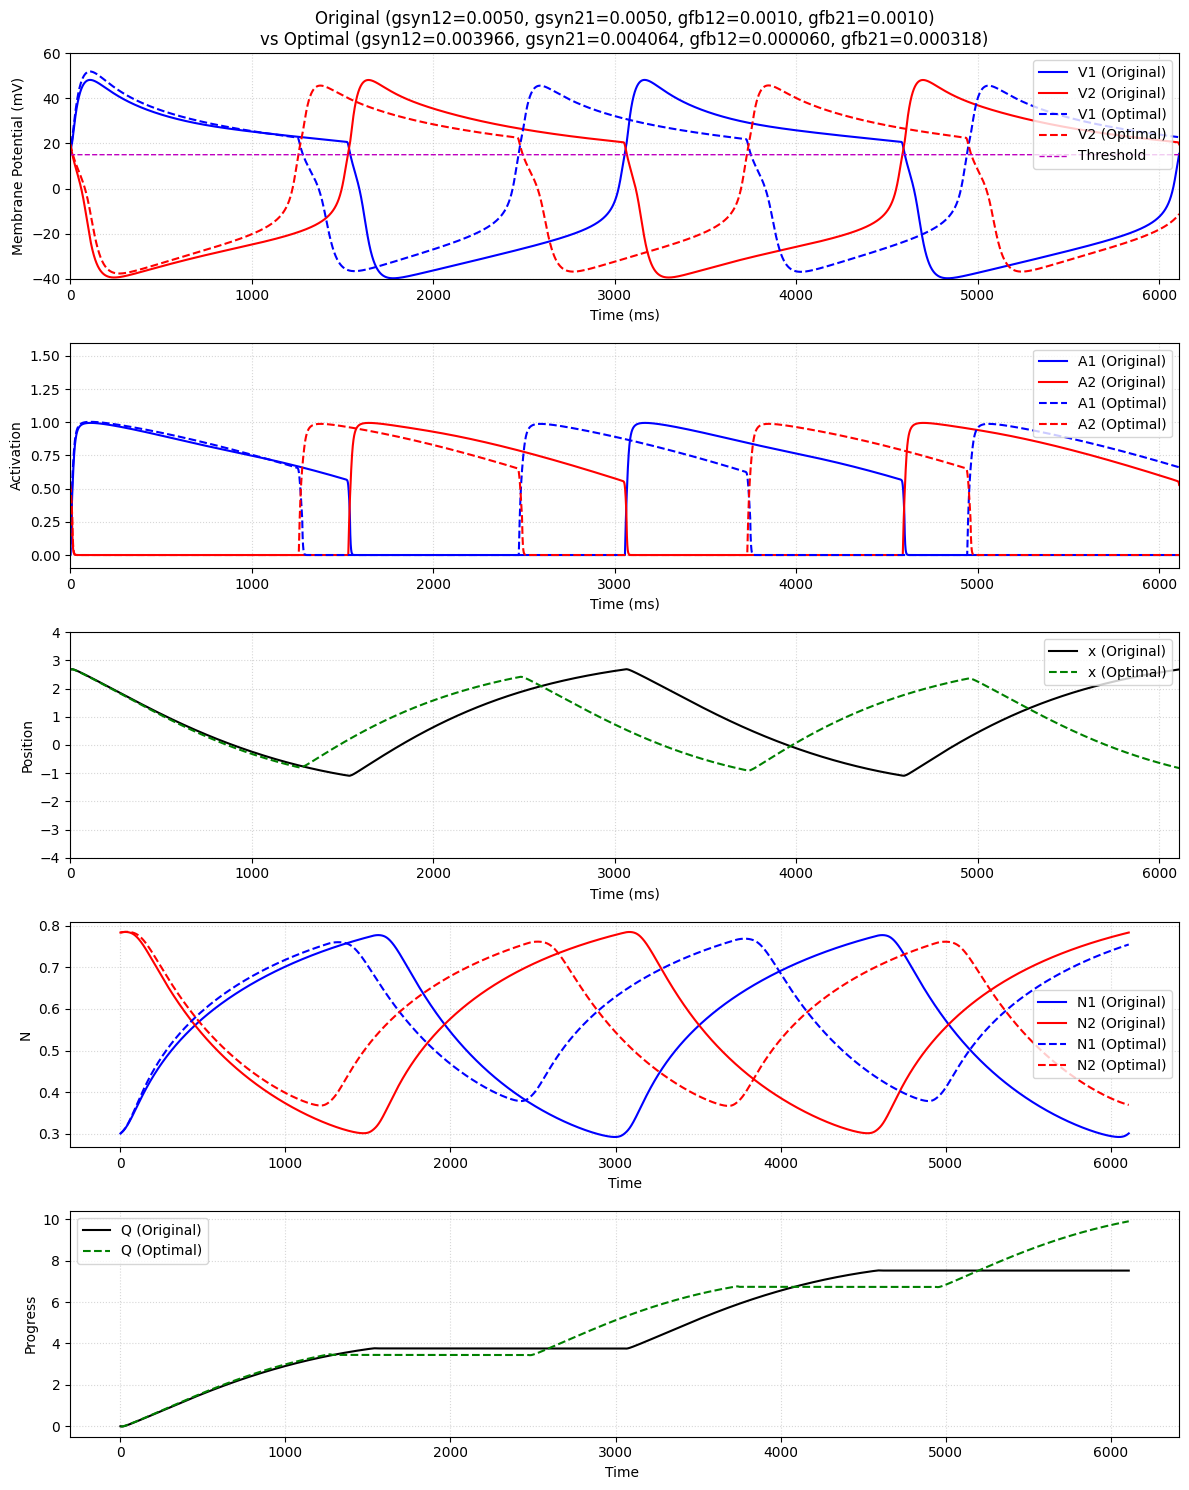

In [10]:
def solution(gsyn12, gsyn21, gfb12, gfb21, label):
    model = h.Section(name='model')
    model.insert('brainb')
    model.insert('bodyb')
    seg = model(0.5)

    seg.brainb.gsyn12 = gsyn12
    seg.brainb.gsyn21 = gsyn21
    seg.brainb.gfb12 = gfb12
    seg.brainb.gfb21 = gfb21
    
 
    seg.brainb._ref_L1Pointer = seg.bodyb._ref_L1
    seg.brainb._ref_L2Pointer = seg.bodyb._ref_L2
    seg.bodyb._ref_V1Pointer = seg.brainb._ref_V1
    seg.bodyb._ref_V2Pointer = seg.brainb._ref_V2

    results = {
        'N1': h.Vector(),
        'N2': h.Vector(),
        'V1': h.Vector(),
        'V2': h.Vector(),
        'A1': h.Vector(),
        'A2': h.Vector(),
        'x': h.Vector(),
        'Q': h.Vector(),
        't': h.Vector(),
        'label': label
    }
    
    #  recording
    results['N1'].record(seg.brainb._ref_N1)
    results['N2'].record(seg.brainb._ref_N2)
    results['V1'].record(seg.brainb._ref_V1)
    results['V2'].record(seg.brainb._ref_V2)
    results['A1'].record(seg.bodyb._ref_A1)
    results['A2'].record(seg.bodyb._ref_A2)
    results['x'].record(seg.bodyb._ref_x)
    results['Q'].record(seg.bodyb._ref_Q)
    results['t'].record(h._ref_t)


    h.load_file('stdrun.hoc')
    h.init()
    h.cvode.active(0)  # Using fixed time step
    h.dt = 0.1        
    h.tstop = 2*T
    h.run()
    
    # Convert to numpy arrays
    for key in results:
        if key != 'label':
            results[key] = np.array(results[key])
    
    return results

# Run simulations
original_results = solution(original_gsyn12, original_gsyn21,  original_gfb12, original_gfb21, "Original")
optimal_results = solution(best_params[0], best_params[1],best_params[2], best_params[3],"Optimal")


plt.figure(figsize=(12, 15))


ax1 = plt.subplot(511)
ax1.plot(original_results['t'], original_results['V1'], 'b-', label=f'V1 ({original_results["label"]})')
ax1.plot(original_results['t'], original_results['V2'], 'r-', label=f'V2 ({original_results["label"]})')
ax1.plot(optimal_results['t'], optimal_results['V1'], 'b--', linewidth=1.5, label=f'V1 ({optimal_results["label"]})')
ax1.plot(optimal_results['t'], optimal_results['V2'], 'r--', linewidth=1.5, label=f'V2 ({optimal_results["label"]})')
ax1.plot(optimal_results['t'], 15*np.ones(len(optimal_results['t'])), '--m', linewidth=1, label='Threshold')
ax1.set_xlim(0, h.tstop)
ax1.set_ylim(-40, 60)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Membrane Potential (mV)')
ax1.legend(loc='upper right')
ax1.set_title(f'Original (gsyn12={original_gsyn12:.4f}, gsyn21={original_gsyn21:.4f}, gfb12={original_gfb12:.4f}, gfb21={original_gfb21:.4f})\n'
              f'vs Optimal (gsyn12={best_params[0]:.6f}, gsyn21={best_params[1]:.6f}, gfb12={best_params[2]:.6f}, gfb21={best_params[3]:.6f})')
ax1.grid(True, linestyle=':', alpha=0.5)


ax2 = plt.subplot(512)
ax2.plot(original_results['t'], original_results['A1'], 'b-', label=f'A1 ({original_results["label"]})')
ax2.plot(original_results['t'], original_results['A2'], 'r-', label=f'A2 ({original_results["label"]})')
ax2.plot(optimal_results['t'], optimal_results['A1'], 'b--', linewidth=1.5, label=f'A1 ({optimal_results["label"]})')
ax2.plot(optimal_results['t'], optimal_results['A2'], 'r--', linewidth=1.5, label=f'A2 ({optimal_results["label"]})')
ax2.set_xlim(0, h.tstop)
ax2.set_ylim(-0.1, 1.6)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Activation')
ax2.legend(loc='upper right')
ax2.grid(True, linestyle=':', alpha=0.5)


ax3 = plt.subplot(513)
ax3.plot(original_results['t'], original_results['x'], 'k-', label=f'x ({original_results["label"]})')
ax3.plot(optimal_results['t'], optimal_results['x'], 'g--', linewidth=1.5, label=f'x ({optimal_results["label"]})')
ax3.set_xlim(0, h.tstop)
ax3.set_ylim(-4, 4)
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Position')
ax3.legend(loc='upper right')
ax3.grid(True, linestyle=':', alpha=0.5)


ax4 = plt.subplot(514)
ax4.plot(original_results['t'], original_results['N1'], 'b-', label=f'N1 ({original_results["label"]})')
ax4.plot(original_results['t'], original_results['N2'], 'r-', label=f'N2 ({original_results["label"]})')
ax4.plot(optimal_results['t'], optimal_results['N1'], 'b--', linewidth=1.5, label=f'N1 ({optimal_results["label"]})')
ax4.plot(optimal_results['t'], optimal_results['N2'], 'r--', linewidth=1.5, label=f'N2 ({optimal_results["label"]})')
ax4.set_xlabel('Time')
ax4.set_ylabel('N')
ax4.legend()
ax4.grid(True, linestyle=':', alpha=0.5)


ax5 = plt.subplot(515)
ax5.plot(original_results['t'], original_results['Q'], 'k-', label=f'Q ({original_results["label"]})')
ax5.plot(optimal_results['t'], optimal_results['Q'], 'g--', linewidth=1.5, label=f'Q ({optimal_results["label"]})')
ax5.set_xlabel('Time ')
ax5.set_ylabel('Progress')
ax5.legend()
ax5.grid(True, linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()